## Setting Up the Environment

In [1]:
import tensorflow as tf
from __future__ import absolute_import, division, print_function, unicode_literals
print("Keras Version: ", tf.keras.__version__)

Keras Version:  2.10.0


Keras Version:  2.9.0


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

[]


In [3]:
train_dir = 'data/fruits-360_dataset/fruits-360/Training'

In [4]:
test_dir = 'data/fruits-360_dataset/fruits-360/Test'

# load these images off disk using image_dataset_from_directory
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory
Old solution: Use ImageDataGenerator to rescale the images: https://keras.io/preprocessing/image/

In [5]:
base_dir = '/'
print(base_dir)

/


In [6]:
batch_size = 32
img_height = 128 #180
img_width = 128 #180

In [7]:
# Establishes a Pipe line instead of loading the dataset directly
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 67692 files belonging to 131 classes.
Using 54154 files for training.


In [8]:
class_names = train_ds.class_names
print(class_names)

['Apple Braeburn', 'Apple Crimson Snow', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith', 'Apple Pink Lady', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Banana Lady Finger', 'Banana Red', 'Beetroot', 'Blueberry', 'Cactus fruit', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cauliflower', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow', 'Chestnut', 'Clementine', 'Cocos', 'Corn', 'Corn Husk', 'Cucumber Ripe', 'Cucumber Ripe 2', 'Dates', 'Eggplant', 'Fig', 'Ginger Root', 'Granadilla', 'Grape Blue', 'Grape Pink', 'Grape White', 'Grape White 2', 'Grape White 3', 'Grape White 4', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Hazelnut', 'Huckleberry', 'Kaki', 'Kiwi', 'Kohlrabi', 'Kumquats', 'Lemon', 'Lemon Meyer', 'Limes', 'Lychee', 'Mandarine', 'Mango', 'Mango Red', 'Mangostan', 'Maracuja', 'Melo

In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 67692 files belonging to 131 classes.
Using 13538 files for validation.


2022-11-24 10:02:05.074151: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


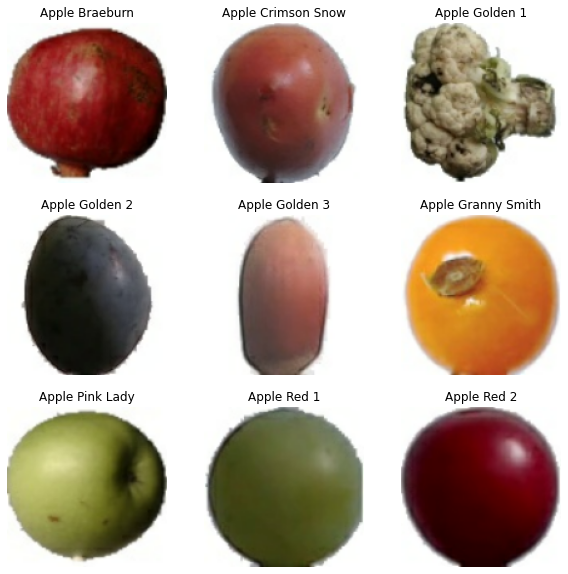

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, groundlabels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[i])
    plt.axis("off")

In [11]:
#manually iterate over the dataset and retrieve batches of images:
#This is a batch of 32 images of shape 180x180x3 (the last dimension referes to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 128, 128, 3)
(32,)


In [ ]:
# number of batches
train_ds.cardinality().numpy()

1693

In [12]:
#Standardize the data, standardize values [0, 255] to be in the [0, 1]
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

#There are two ways to use this layer. You can apply it to the dataset by calling map:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.14575292 1.0


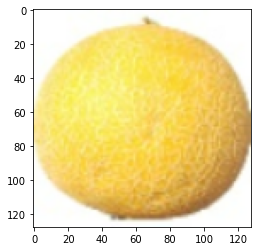

In [13]:

plt.imshow(first_image)

# Train a model

In [14]:
#Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
num_classes = len(class_names)
num_classes

131

In [16]:
model = tf.keras.Sequential([
  #layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [17]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [19]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
1693/1693 [==============================] - 125s 74ms/step - loss: 0.0602 - accuracy: 0.9844 - val_loss: 0.2166 - val_accuracy: 0.9648
Epoch 2/3
1693/1693 [==============================] - 125s 74ms/step - loss: 0.0775 - accuracy: 0.9808 - val_loss: 0.0301 - val_accuracy: 0.9929
Epoch 3/3
1693/1693 [==============================] - 124s 73ms/step - loss: 0.0461 - accuracy: 0.9886 - val_loss: 0.1646 - val_accuracy: 0.9633


In [20]:
def plot_history(history, metric, val_metric):
  acc = history.history[metric]
  val_acc = history.history[val_metric]

  loss=history.history['loss']
  val_loss=history.history['val_loss']

  epochs_range = range(len(acc))

  fig=plt.figure(figsize=(12, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylim([min(plt.ylim()),1])
  plt.grid(True)
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.grid(True)
  plt.title('Training and Validation Loss')
  plt.show()
  fig.savefig('traininghistory.pdf')



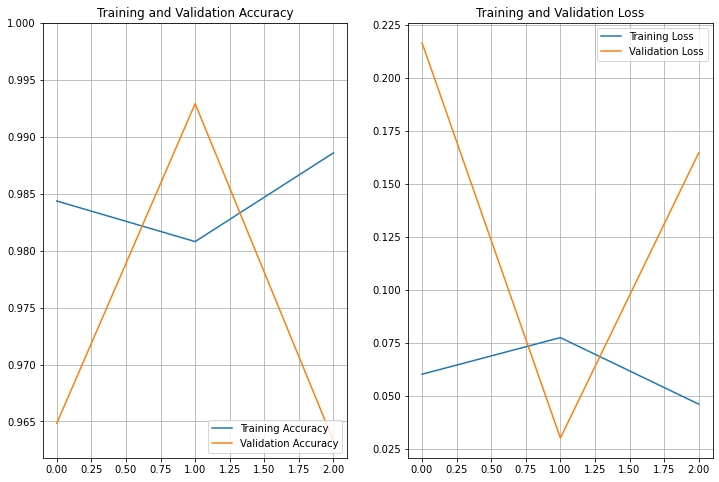

In [21]:
plot_history(history, 'accuracy', 'val_accuracy')

In [22]:
model.save('saved_models/simple_model/', save_format='tf')


INFO:tensorflow:Assets written to: saved_models/simple_model/assets


INFO:tensorflow:Assets written to: saved_models/simple_model/assets


In [24]:
!ls saved_models/simple_model/

assets            keras_metadata.pb saved_model.pb    variables


In [25]:
!zip simple_model.zip -r saved_models/simple_model/

  adding: saved_models/simple_model/ (stored 0%)
  adding: saved_models/simple_model/keras_metadata.pb (deflated 92%)
  adding: saved_models/simple_model/variables/ (stored 0%)
  adding: saved_models/simple_model/variables/variables.data-00000-of-00001 (deflated 6%)
  adding: saved_models/simple_model/variables/variables.index (deflated 67%)
  adding: saved_models/simple_model/saved_model.pb (deflated 89%)
  adding: saved_models/simple_model/assets/ (stored 0%)


In [27]:
model.save('simple_model.h5')

In [ ]:
newsaved_model = tf.keras.models.load_model('saved_models/simple_model/')